In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torchvision
import torchvision.transforms as T

from sklearn.model_selection import train_test_split

import copy

import matplotlib.pyplot as plt

In [ ]:
### MNIST data

data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv','rb'),delimiter=',')

labelsT   = torch.tensor( data[:,0] ).long()
data      = data[:,1:]
dataNorm  = data / np.max(data)
dataNormT = torch.tensor( dataNorm.reshape(dataNorm.shape[0],1,28,28) ).float()

train_data,test_data, train_labels,test_labels = train_test_split(dataNormT, labelsT, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 32
numbers_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
numbers_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
### FMNIST data

transform = T.Compose([ T.ToTensor(), T.Normalize(.5,.5) ])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

batchsize    = 32
fashion_train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
fashion_test_loader  = DataLoader(testset, batch_size=len(testset))

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.9MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.86MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 13.6MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 b/c maxpool)

      expectSize = np.floor( (5+2*0-1)/1 ) + 1
      expectSize = 20*int(expectSize**2)

      self.fc1 = nn.Linear(expectSize,50)
      self.out = nn.Linear(50,10)
      self.print = printtoggle

    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1: {x.shape}') if self.print else None

      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2: {x.shape}') if self.print else None

      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')

      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x

  net = mnistNet(printtoggle)

  lossfun = nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(net.parameters(),lr=.005)

  return net,lossfun,optimizer

In [ ]:
def function2trainTheModel(net,train_loader,test_loader,numepochs=10):

  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  for epochi in range(numepochs):

    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      yHat = net(X)
      loss = lossfun(yHat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      matches = torch.argmax(yHat,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append( accuracyPct )

    trainAcc.append( np.mean(batchAcc) )

    losses[epochi] = np.mean(batchLoss)

    net.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)

    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  return trainAcc,testAcc,losses,net

In [ ]:
numberNet,lossfun,optimizer = createTheMNISTNet()

trainAcc,testAcc,losses,numberNet = function2trainTheModel(numberNet,numbers_train_loader,numbers_test_loader,5)

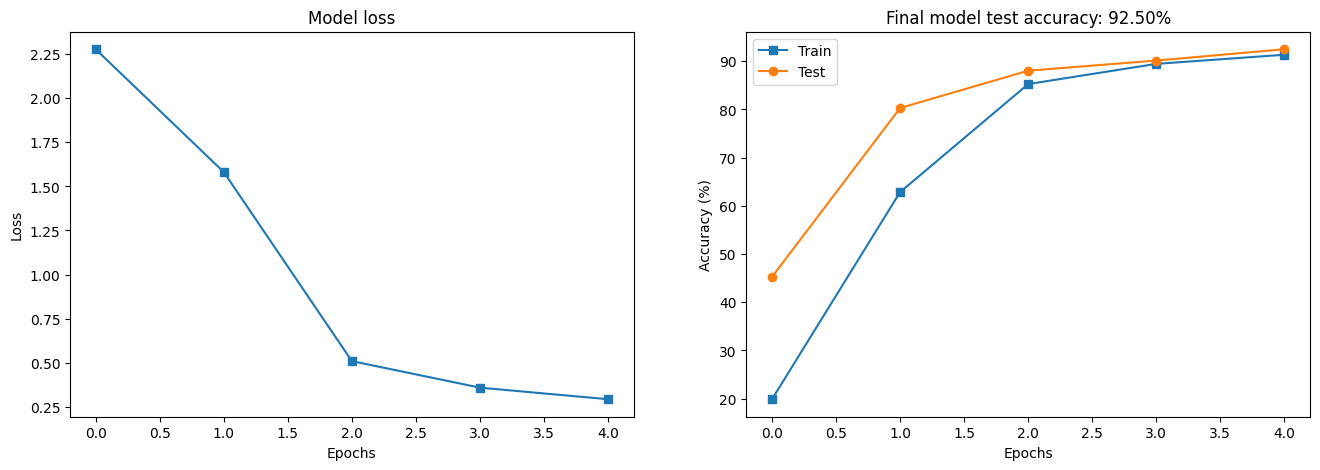

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
X,y = next(iter(fashion_test_loader))
yHat = numberNet(X)

fashionAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
print(f'NUMBERNET performance on FASHION data: {fashionAcc:.2f}%')

NUMBERNET performance on FASHION data: 5.79%


In [ ]:
fashionNet,lossfun,optimizer = createTheMNISTNet()
print( fashionNet.conv1.weight[0] - numberNet.conv1.weight[0] )

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(fashionNet.named_parameters(),numberNet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

print( fashionNet.conv1.weight[0] - numberNet.conv1.weight[0] )

tensor([[[-0.0381, -0.0152, -0.1075,  0.2875, -0.0169],
         [ 0.1274, -0.1164,  0.1656,  0.0144, -0.1149],
         [-0.0835,  0.0733,  0.2244, -0.0561, -0.1064],
         [ 0.0968,  0.3437, -0.0550, -0.1415,  0.0366],
         [ 0.0987,  0.0248, -0.1879,  0.1550, -0.2809]]],
       grad_fn=<SubBackward0>)
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]], grad_fn=<SubBackward0>)


In [ ]:
trainAcc,testAcc,losses,fashionNet = function2trainTheModel(
                                         fashionNet,fashion_train_loader,fashion_test_loader,1)

In [ ]:
print(f'numberNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'numberNet TEST accuracy: {testAcc[-1]:.2f}%')

numberNet TRAIN accuracy: 67.12%
numberNet TEST accuracy: 74.70%
